# Serving Deep Learning Models

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../data/wifi_location.csv')

In [3]:
df.head()

,a_1,a_2,a_3,a_4,a_5,a_6,a_7,location
0,-64,-56,-61,-66,-71,-82,-81,0
1,-68,-57,-61,-65,-71,-85,-85,0
2,-63,-60,-60,-67,-76,-85,-84,0
3,-61,-60,-68,-62,-77,-90,-80,0
4,-63,-65,-60,-63,-77,-81,-87,0


In [4]:
df['location'].value_counts()

3    500
2    500
1    500
0    500
Name: location, dtype: int64

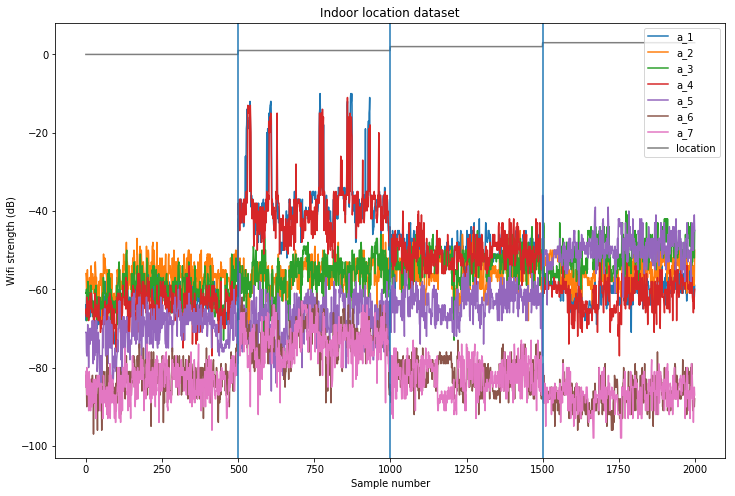

In [5]:
df.plot(figsize=(12, 8))
plt.axvline(500)
plt.axvline(1000)
plt.axvline(1500)
plt.title('Indoor location dataset')
plt.xlabel('Sample number')
plt.ylabel('Wifi strength (dB)');

In [6]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


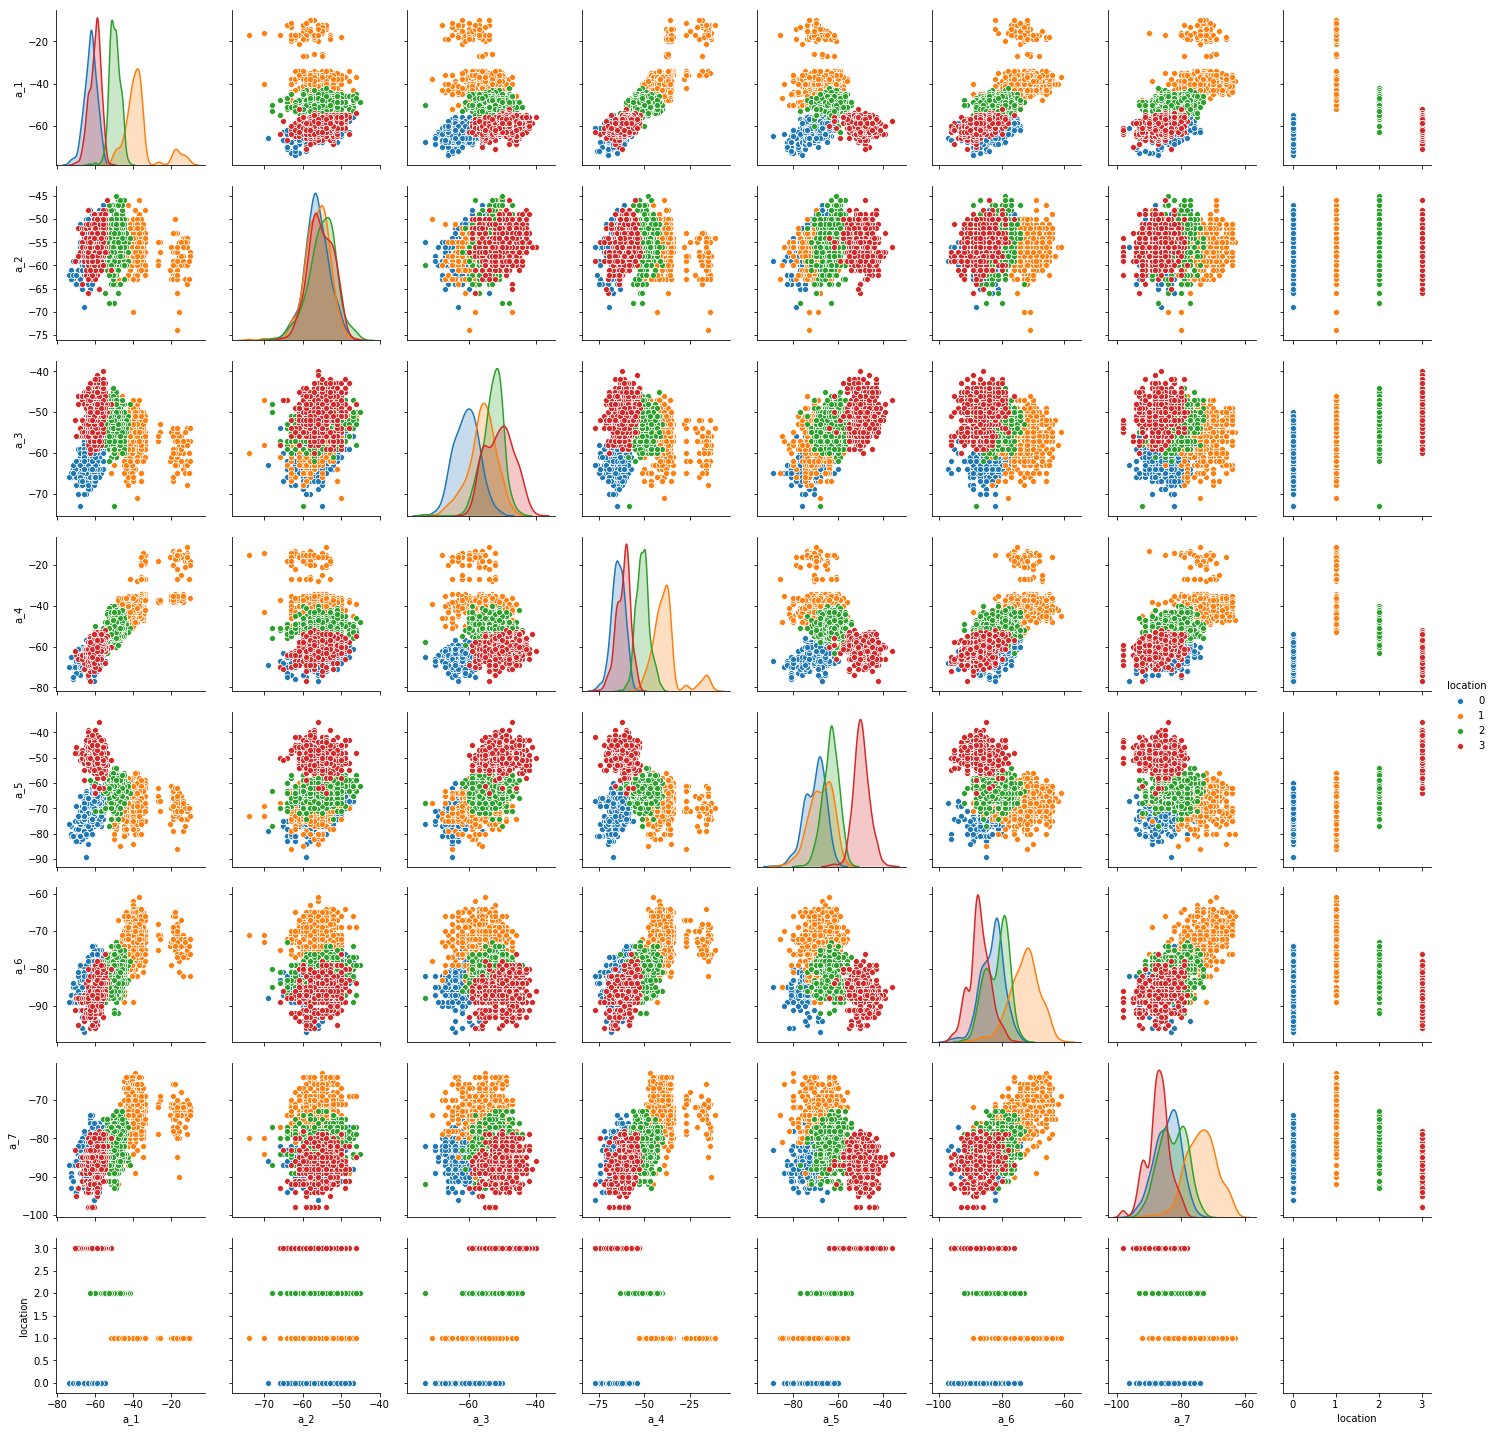

In [7]:
sns.pairplot(df, hue='location');

In [8]:
X = df.drop('location', axis=1).values
y = df['location'].values

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [11]:
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization

Using TensorFlow backend.


In [12]:
inputs = Input(shape=X_train.shape[1:])
x = BatchNormalization()(inputs) # don't need normalize manually when using this
x = Dense(50, activation='relu')(x)
x = Dense(30, activation='relu')(x)
x = Dense(10, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7)                 28        
_________________________________________________________________
dense_1 (Dense)              (None, 50)                400       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 44        
Total params: 2,312
Trainable params: 2,298
Non-trainable params: 14
_________________________________________________________________


In [14]:
model.compile('adam',
              'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
h = model.fit(X_train, y_train,
              batch_size=128,
              epochs=40,
              verbose=0,
              validation_data=(X_test, y_test))

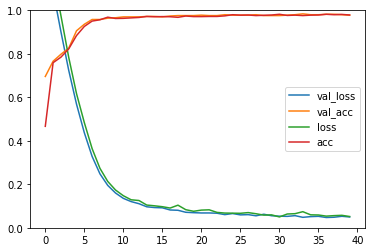

In [16]:
pd.DataFrame(h.history).plot()
plt.ylim(0, 1);

In [17]:
import os  # Miscellaneous operating system interfaces
import json  # JSON encoder and decoder
import shutil  # High-level file operations

In [18]:
base_path = '/tmp/ztdl_models/wifi'
sub_path = 'flask'
version = 1

In [19]:
from os.path import join

In [20]:
export_path = join(base_path, sub_path, str(version))
export_path

'/tmp/ztdl_models/wifi/flask/1'

In [21]:
shutil.rmtree(export_path, ignore_errors=True)  # delete path, if exists
os.makedirs(export_path)  # create path

In [22]:
json.loads(model.to_json())

{'class_name': 'Model',
 'config': {'name': 'model_1',
  'layers': [{'name': 'input_1',
    'class_name': 'InputLayer',
    'config': {'batch_input_shape': [None, 7],
     'dtype': 'float32',
     'sparse': False,
     'name': 'input_1'},
    'inbound_nodes': []},
   {'name': 'batch_normalization_1',
    'class_name': 'BatchNormalization',
    'config': {'name': 'batch_normalization_1',
     'trainable': True,
     'axis': -1,
     'momentum': 0.99,
     'epsilon': 0.001,
     'center': True,
     'scale': True,
     'beta_initializer': {'class_name': 'Zeros', 'config': {}},
     'gamma_initializer': {'class_name': 'Ones', 'config': {}},
     'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}},
     'moving_variance_initializer': {'class_name': 'Ones', 'config': {}},
     'beta_regularizer': None,
     'gamma_regularizer': None,
     'beta_constraint': None,
     'gamma_constraint': None},
    'inbound_nodes': [[['input_1', 0, 0, {}]]]},
   {'name': 'dense_1',
    'class_n

In [23]:
with open(join(export_path, 'model.json'), 'w') as fout:
    fout.write(model.to_json())

In [24]:
model.save_weights(join(export_path, 'weights.h5'))

In [25]:
os.listdir(export_path, )

['model.json', 'weights.h5']

In [26]:
from keras.models import model_from_json

In [27]:
with open(join(export_path, 'model.json')) as fin:
    loaded_model = model_from_json(fin.read())

In [28]:
probas = loaded_model.predict(X_test)
probas

array([[1.3129653e-04, 9.9058546e-02, 8.9893758e-01, 1.8725418e-03],
       [6.5125496e-04, 1.5198563e-01, 8.4269220e-01, 4.6709646e-03],
       [4.5238610e-04, 1.5347910e-01, 8.4218079e-01, 3.8876953e-03],
       ...,
       [6.5855443e-04, 1.4689930e-01, 8.4788400e-01, 4.5580571e-03],
       [2.0976702e-04, 6.2827416e-02, 9.3473113e-01, 2.2316587e-03],
       [4.9030071e-04, 2.3240693e-01, 7.6388150e-01, 3.2212837e-03]],
      dtype=float32)

In [29]:
preds = np.argmax(probas, axis=1)
preds

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [30]:
from sklearn.metrics import accuracy_score

In [31]:
accuracy_score(y_test, preds)

0.256

In [32]:
loaded_model.load_weights(join(export_path, 'weights.h5'))

In [33]:
probas = loaded_model.predict(X_test)  # class probabilities
preds = np.argmax(probas, axis=1)  # class prediction
accuracy_score(y_test, preds)  # accuracy score

0.978

## A simple deployment with Flask

In [34]:
!cat ./model_serving/flask_serve_model.py

import os
import json
import numpy as np
from keras.models import model_from_json

from flask import Flask
from flask import request, jsonify
import tensorflow as tf

loaded_model = None
graph = None

app = Flask(__name__)


def load_model(export_path):
    """
    Load model and tensorflow graph
    into global variables.
    """

    # global variables
    global loaded_model
    global graph

    # load model architecture from json
    with open(os.path.join(export_path, 'model.json')) as fin:
        loaded_model = model_from_json(fin.read())

    # load weights
    loaded_model.load_weights(os.path.join(export_path, 'weights.h5'))

    # get the tensorflow graph
    graph = tf.get_default_graph()
    print("Model loaded.")


def preprocess(data):
    """
    Generic function for normalization
    and feature engineering.
    Convert data from json to numpy array.
    """
    res = json.loads(data)
    return np.array(res['data'])


@app.route('/', methods=["POST"])
def predict():


## Exercise 1

Open a terminal and run the script with command:

```
CUDA_VISIBLE_DEVICES="" python model_serving/flask_serve_model.py
```

Then come back here and continue

In [41]:
import requests

In [42]:
api_url = "http://localhost:5000/"

In [43]:
data = X_test[:5].tolist()

In [44]:
data

[[-62, -58, -59, -59, -67, -80, -77],
 [-49, -53, -50, -48, -67, -78, -88],
 [-52, -57, -49, -50, -66, -80, -80],
 [-40, -55, -52, -43, -60, -76, -72],
 [-64, -59, -51, -67, -43, -88, -92]]

In [45]:
payload = {'data': data}
headers = {'content-type': 'application/json'}

In [46]:
response = requests.post(api_url,
                         data=json.dumps(payload),
                         headers=headers)

In [47]:
response

<Response [200]>

In [48]:
response.json()

[0, 2, 2, 1, 3]

In [49]:
y_test[:5]

array([0, 2, 2, 1, 3])

## Deployment with Tensorflow Serving

As the [documentation](https://www.tensorflow.org/serving/) says, TensorFlow Serving is a flexible, high-performance serving system for Machine Learning models, designed for production environments. TensorFlow Serving makes it easy to deploy new algorithms and experiments, while keeping the same server architecture and APIs. TensorFlow Serving provides out-of-the-box integration with TensorFlow models, but can be easily extended to serve other types of models and data.

Tensorflow Serving can accommodate both small and large deployments, and it is built for production. It is not as simple as Flask, and here we will barely scratch the surface of what it's possible with it. If you are serious about using it, we strongly recommend you take a look at the [Architecture overview](https://www.tensorflow.org/serving/architecture_overview) where many concepts like Servables, Managers and Sources are explained.

In this part of the book, we will just show you how to export a model for serving and how to ping a Tensorflow serving server. We will leave the full installation of Tensorflow serving for the end of the chapter. Installation is strongly dependent on the system you are using and is [well documented](https://www.tensorflow.org/serving/).

In [50]:
import tensorflow as tf

In [51]:
base_path = '/tmp/ztdl_models/wifi'
sub_path = 'tfserving'
version = 1

In [52]:
export_path = join(base_path, sub_path, str(version))
export_path

'/tmp/ztdl_models/wifi/tfserving/1'

In [53]:
shutil.rmtree(export_path, ignore_errors=True)

In [54]:
from tensorflow.python.saved_model.builder import SavedModelBuilder

In [55]:
builder = SavedModelBuilder(export_path)

In [56]:
from tensorflow.python.saved_model.signature_def_utils \
    import predict_signature_def

In [57]:
signature = predict_signature_def(
    inputs={"inputs": model.input},
    outputs={"outputs": model.output})

In [59]:
import keras.backend as K

In [60]:
sess = K.get_session()

In [61]:
builder.add_meta_graph_and_variables(
    sess=sess,
    tags=[tf.saved_model.tag_constants.SERVING],
    signature_def_map={'predict': signature})

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.


In [62]:
builder.save()

INFO:tensorflow:SavedModel written to: /tmp/ztdl_models/wifi/tfserving/1/saved_model.pb


b'/tmp/ztdl_models/wifi/tfserving/1/saved_model.pb'

In [63]:
os.listdir(export_path)

['saved_model.pb', 'variables']

In [64]:
os.listdir(join(export_path, 'variables'))

['variables.data-00000-of-00001', 'variables.index']

## Exercise 2

Go back to the terminal, stop the flask serving script and start tensorflow serving with the following command:

```
CUDA_VISIBLE_DEVICES="" tensorflow_model_server \
                           --port=8500 \
                           --model_name=wifi \
                           --model_base_path=/tmp/ztdl_models/wifi/tfserving/
```

Then come back here and continue.

In [65]:
from grpc import insecure_channel

In [66]:
channel = insecure_channel('localhost:8500')

In [67]:
channel

In [68]:
from tensorflow_serving.apis.prediction_service_pb2_grpc import PredictionServiceStub

In [69]:
stub = PredictionServiceStub(channel)

In [70]:
data

[[-62, -58, -59, -59, -67, -80, -77],
 [-49, -53, -50, -48, -67, -78, -88],
 [-52, -57, -49, -50, -66, -80, -80],
 [-40, -55, -52, -43, -60, -76, -72],
 [-64, -59, -51, -67, -43, -88, -92]]

In [71]:
from tensorflow.contrib.util import make_tensor_proto

In [72]:
data_np = np.array(data)

In [75]:
data_np

array([[-62, -58, -59, -59, -67, -80, -77],
       [-49, -53, -50, -48, -67, -78, -88],
       [-52, -57, -49, -50, -66, -80, -80],
       [-40, -55, -52, -43, -60, -76, -72],
       [-64, -59, -51, -67, -43, -88, -92]])

In [73]:
data_pb = make_tensor_proto(data_np,
                            dtype='float',
                            shape=data_np.shape)

In [74]:
data_pb

dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 5
  }
  dim {
    size: 7
  }
}
tensor_content: "\000\000x\302\000\000h\302\000\000l\302\000\000l\302\000\000\206\302\000\000\240\302\000\000\232\302\000\000D\302\000\000T\302\000\000H\302\000\000@\302\000\000\206\302\000\000\234\302\000\000\260\302\000\000P\302\000\000d\302\000\000D\302\000\000H\302\000\000\204\302\000\000\240\302\000\000\240\302\000\000 \302\000\000\\\302\000\000P\302\000\000,\302\000\000p\302\000\000\230\302\000\000\220\302\000\000\200\302\000\000l\302\000\000L\302\000\000\206\302\000\000,\302\000\000\260\302\000\000\270\302"

In [76]:
from tensorflow_serving.apis.predict_pb2 import PredictRequest

In [77]:
request = PredictRequest()

In [78]:
request.model_spec.name = 'wifi'

In [79]:
request.model_spec.signature_name = 'predict'

In [80]:
request.inputs['inputs'].CopyFrom(data_pb)

In [81]:
request

model_spec {
  name: "wifi"
  signature_name: "predict"
}
inputs {
  key: "inputs"
  value {
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: 5
      }
      dim {
        size: 7
      }
    }
    tensor_content: "\000\000x\302\000\000h\302\000\000l\302\000\000l\302\000\000\206\302\000\000\240\302\000\000\232\302\000\000D\302\000\000T\302\000\000H\302\000\000@\302\000\000\206\302\000\000\234\302\000\000\260\302\000\000P\302\000\000d\302\000\000D\302\000\000H\302\000\000\204\302\000\000\240\302\000\000\240\302\000\000 \302\000\000\\\302\000\000P\302\000\000,\302\000\000p\302\000\000\230\302\000\000\220\302\000\000\200\302\000\000l\302\000\000L\302\000\000\206\302\000\000,\302\000\000\260\302\000\000\270\302"
  }
}

In [82]:
result_future = stub.Predict.future(request, 5.0)

In [84]:
result = result_future.result()
result

outputs {
  key: "outputs"
  value {
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: 5
      }
      dim {
        size: 4
      }
    }
    float_val: 0.9927908182144165
    float_val: 0.0013238743413239717
    float_val: 0.003993101883679628
    float_val: 0.0018922163872048259
    float_val: 0.00021006088354624808
    float_val: 0.005767202004790306
    float_val: 0.9940153956413269
    float_val: 7.395475677185459e-06
    float_val: 0.002195051172748208
    float_val: 0.008498589508235455
    float_val: 0.9892404675483704
    float_val: 6.586933886865154e-05
    float_val: 4.083433668711223e-05
    float_val: 0.9384275078773499
    float_val: 0.06153121963143349
    float_val: 4.1046732235372474e-07
    float_val: 1.9392405192775186e-07
    float_val: 8.694832076550085e-10
    float_val: 8.228393539866374e-07
    float_val: 0.999998927116394
  }
}
model_spec {
  name: "wifi"
  version {
    value: 1
  }
  signature_name: "predict"
}

In [85]:
from tensorflow.contrib.util import make_ndarray

In [86]:
scores = make_ndarray(result.outputs['outputs'])

In [87]:
scores

array([[9.9279082e-01, 1.3238743e-03, 3.9931019e-03, 1.8922164e-03],
       [2.1006088e-04, 5.7672020e-03, 9.9401540e-01, 7.3954757e-06],
       [2.1950512e-03, 8.4985895e-03, 9.8924047e-01, 6.5869339e-05],
       [4.0834337e-05, 9.3842751e-01, 6.1531220e-02, 4.1046732e-07],
       [1.9392405e-07, 8.6948321e-10, 8.2283935e-07, 9.9999893e-01]],
      dtype=float32)

In [88]:
prediction = np.argmax(scores, axis=1)
prediction

array([0, 2, 2, 1, 3])

In [89]:
model.predict(np.array(data)).argmax(axis=1)

array([0, 2, 2, 1, 3])